In [1]:
# Custom Imports
from polysaccharide import analysis, filetree, general, logutils, molutils
from polysaccharide import simulation as polysim
from polysaccharide import representation as rep

from polysaccharide import charging
from polysaccharide.charging.types import AtomIDMap, ResidueChargeMap
from polysaccharide.charging.residues import ChargedResidue
from polysaccharide.charging.application import CHARGER_REGISTRY, ChargingParameters

from polysaccharide import LOGGERS_MASTER
from polysaccharide.logutils import ProcessLogHandler
from polysaccharide.representation import Polymer, PolymerManager, has_sims
from polysaccharide.solvation.solvents import WATER_TIP3P
from polysaccharide.analysis import plotprops, trajectory, statistics
from polysaccharide.simulation import SimulationPaths, SimulationParameters
from polysaccharide.graphics import rdkdraw, plotutils


# Generic Imports
import re
from functools import partial
from collections import defaultdict
from itertools import combinations

# Numeric imports
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# File I/O
from pathlib import Path
import csv, json, pickle
from shutil import copyfile, rmtree
import importlib.resources as impres

# Logging and Shell
import logging
logging.basicConfig(level=logging.INFO)
                            
# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdmolfiles

# Molecular Dynamics
from openff.interchange import Interchange
from openff.toolkit import ForceField
from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import Molecule, Atom
from openff.toolkit.typing.engines.smirnoff.parameters import LibraryChargeHandler

from openff.units import unit
from openmm.unit import picosecond, femtosecond, nanosecond # time
from openmm.unit import nanometer, angstrom # length
from openmm.unit import kelvin, atmosphere # misc

# polymer resource management
import importlib_resources as impres
import resources
RESOURCE_PATH = impres.files(resources)

# Static Paths
# RESOURCE_PATH = Path('resources')
COLL_PATH = Path('Collections')
# COMPAT_PDB_PATH = Path('compatible_pdbs')
COMPAT_PDB_PATH = Path('compatible_pdbs_updated')

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Loading Polymer Manager

In [13]:
reset      = False 
purge_sims = False  
purge_logs = False 

# poly_source_path = COMPAT_PDB_PATH / 'simple_polymers'
# poly_source_path = COMPAT_PDB_PATH / 'water_soluble_polymers'
# poly_source_path = COMPAT_PDB_PATH / 'water_soluble_reduced'
poly_source_path = COMPAT_PDB_PATH / 'water_soluble_large'
solv_template    = RESOURCE_PATH/'inp_templates'/'solv_polymer_template_box.inp'
desired_solvents = (WATER_TIP3P,) # (None,)
exclusion = 1.0*nanometer

# Define derived paths and create manager
collection_path  = COLL_PATH / poly_source_path.name
structure_path   = poly_source_path / f'{poly_source_path.name}_structures'
monomer_path     = poly_source_path / f'{poly_source_path.name}_monomers'

mgr = PolymerManager(collection_path)

# Perform manager setup / purge actions
if purge_logs: # NOTE : must be done BEFORE log FileHandler is created, as this will destroy it's output as well
    mgr.purge_logs(really=True)

creation_logger = logging.getLogger('polymer_setup')
loggers = [creation_logger, *LOGGERS_MASTER]

with ProcessLogHandler(filedir=mgr.log_dir, loggers=loggers, proc_name=f'Setup of {mgr.collection_dir.name}', timestamp=True):
    if reset:
        mgr.purge_collection(really=True, purge_logs=False) # Explicitly DON'T purge logs here (will be done prior to entering log loop)

    if purge_sims:
        mgr.purge_sims(really=True)

    if not mgr.polymers: # will be empty if not yet instantiated or if reset prior
        mgr.populate_collection(struct_dir=structure_path, monomer_dir=monomer_path)
        mgr.solvate_collection(desired_solvents, template_path=solv_template, exclusion=exclusion)

INFO:8753977474424:Setup of water_soluble_large completed in 0:00:00.000018



## Inspecting monomer matches and fragments

15
IDs match with offmol!


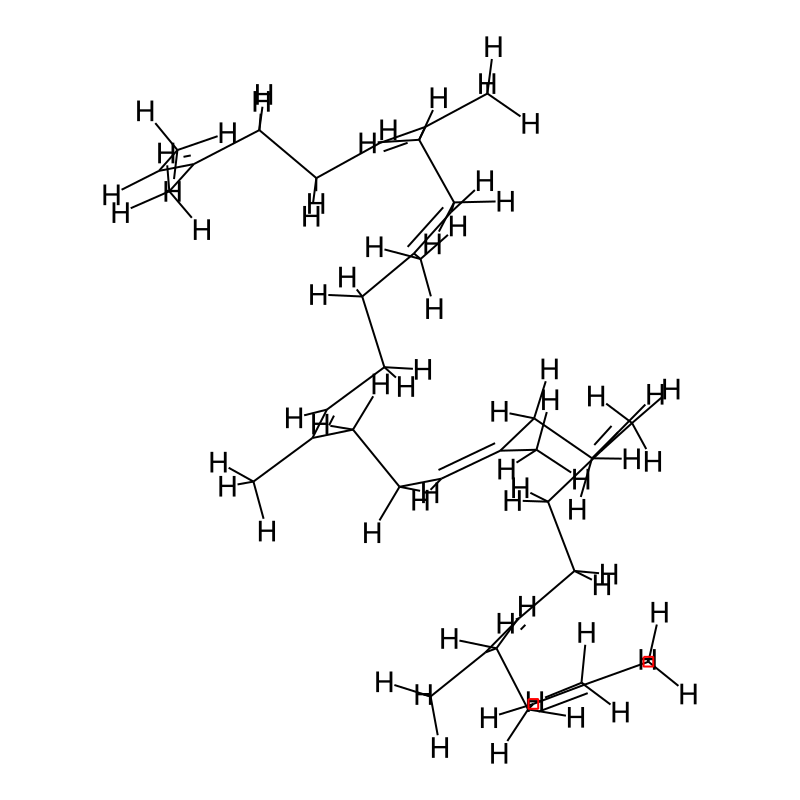

In [4]:
import copy

mol_name = 'naturalrubber_solv_water' 
# mol_name = 'peg_modified' 
# mol_name = 'paam_modified' 
# mol_name = 'pnipam_modified' 
# mol_name = 'peg_modified_solv_water' 
# mol_name = 'pnipam_modified_solv_water' 
# mol_name = 'paam_modified_solv_water'

pdir = mgr.polymers[mol_name]
# offmol = pdir.offmol_matched(strict=False, verbose=False)
offmol = pdir.offmol
rdmol = offmol.to_rdkit()
# rdmol = pdir.rdmol

# Labelled all unmatched atoms
# for i, atom in enumerate(offmol.atoms):
#     rdatom = rdmol.GetAtomWithIdx(i)
#     rdatom.SetProp('atomNote', atom.metadata.get('residue_name', 'unmatched'))
# print('Matched residues : ', set(atom.metadata.get('residue_name') for atom in offmol.atoms))

# Bounding monomer sizes 
max_mono_size = max(Chem.MolFromSmarts(SMARTS).GetNumAtoms() for SMARTS in pdir.monomer_data['monomers'].values())
print(max_mono_size)

# confirming order match with OpenFF
for atom in rdmol.GetAtoms():
    if atom.GetSymbol() != offmol.atoms[atom.GetIdx()].symbol:
        print(f'{atom} mismatched')
else:
    print('IDs match with offmol!')

rdkdraw.set_rdkdraw_size(800, 1/1)
rdmol

In [ ]:
# visualize partial charges (not deltas!)
import matplotlib.colors as mplcolors

pdir.assign_charges_by_lookup('ABE10_averaged')
rdmol_chg = pdir.offmol.to_rdkit()
chgs = pdir.offmol.partial_charges._magnitude

for i, chg in enumerate(chgs):
    rdmol_chg.GetAtomWithIdx(i).SetProp('atomNote', str(round(chg, 4)))

n = 800
cmap = plt.get_cmap('jet')
norm = mplcolors.Normalize(vmin=chgs.min(), vmax=chgs.max())

img = rdkdraw.rdmol_prop_heatmap(rdmol_chg, 'PartialCharge', cmap=cmap, norm=norm, img_size=(n, n))
fig, ax = plotutils.plot_image_with_colorbar(img, cmap, norm, label=f'Magnitude of Partial Charges ({pdir.charge_method})', dim=10)

In [ ]:
# show monomers with charges
rdkdraw.set_rdkdraw_size(300, 3/1)
mono_dat = pdir.monomer_data_charged
for mono_name, mono_SMARTS in mono_dat['monomers'].items():
    chgs = mono_dat['charges'][mono_name]
    norm = mplcolors.Normalize(vmin=min(chgs.values()), vmax=max(chgs.values()))

    monomer = Chem.MolFromSmarts(mono_SMARTS) 
    for atom in monomer.GetAtoms():
        id = atom.GetAtomMapNum()
        chg = chgs.get(id, 0)
        atom.SetProp('atomNote', str(round(chg, 4)))
        atom.SetProp('PartialCharge', str(round(chg, 4)))
        atom.SetAtomMapNum(0)

    img = rdkdraw.rdmol_prop_heatmap(monomer, 'PartialCharge', cmap=cmap, norm=norm, img_size=(n, round(n / 1.5)))
    fig, ax = plotutils.plot_image_with_colorbar(img, cmap, norm, label=f'Magnitude of Partial Charges ({pdir.charge_method})', dim=10, aspect=1/2)
    plt.show()
    # print(mono_name, monomer.GetNumAtoms(), mono_SMARTS, monomer.GetNumAtoms())
    # display(monomer)

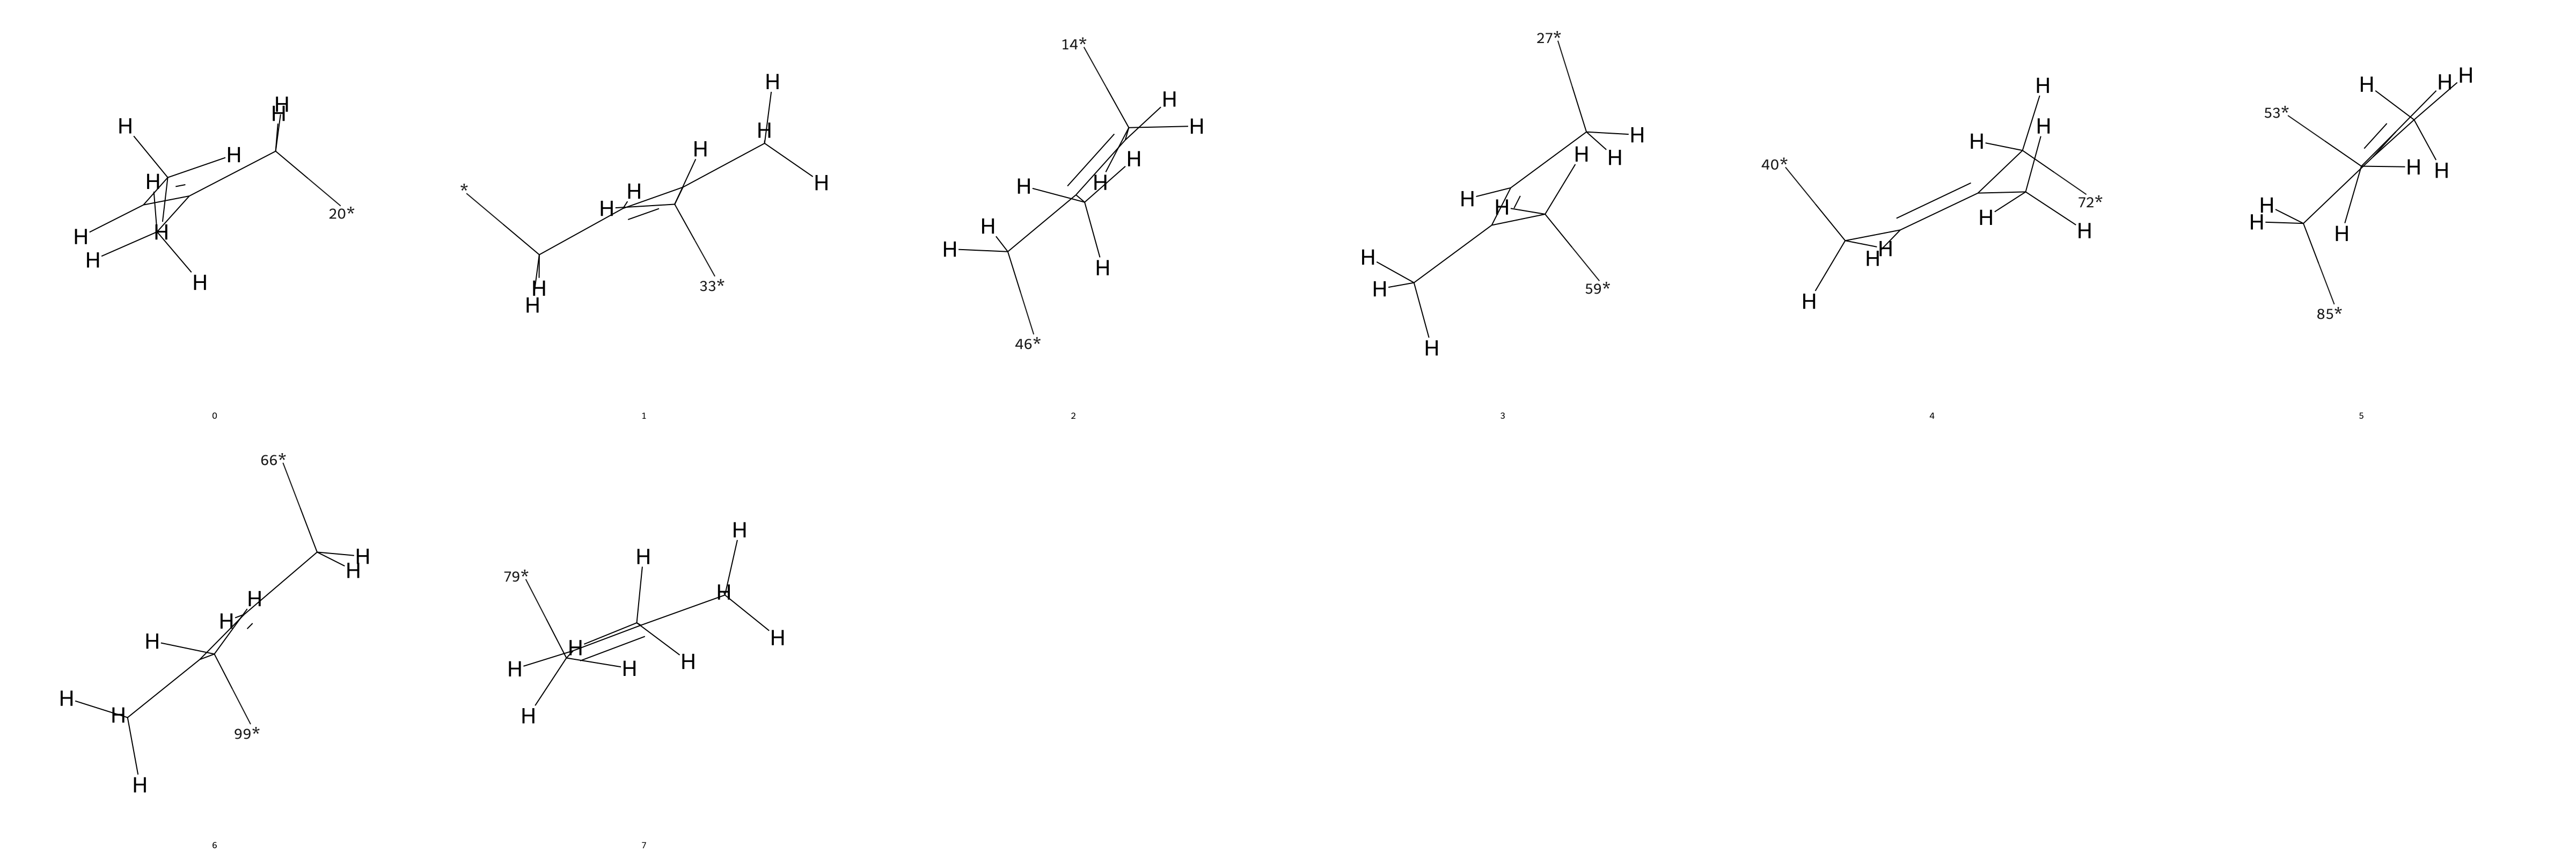

In [10]:
# show individual constituent monomers
from rdkit.Chem.Draw import MolsToGridImage
import polysaccharide.molutils.rdmol.fragment as frag 

offmol = pdir.offmol
rdmol  = offmol.to_rdkit()

ids = frag.inter_monomer_bond_indices(offmol)
frags_solv = frag.fragment_by_bond_indices(rdmol, ids)
rdkdraw.set_rdkdraw_size(800, 1/1)

n = 800
MolsToGridImage(frags_solv, molsPerRow=6, subImgSize=(n, n), legends=[str(i) for i, _ in enumerate(frags_solv)])

In [12]:
frag_mol = Molecule.from_rdkit(frags_solv[0], allow_undefined_stereo=True, hydrogens_are_explicit=True)

 - Bond 3 (atoms 3-4 of element (C-C)



ValueError: atomic number must be positive, given 0.

## Testing Polymer building and from-monomer calculations

In [ ]:
for pdir in mgr.polymers_list:
    if pdir.has_monomer_data:
        mono = pdir.monomer_data['monomers']
        print(pdir.mol_name, abmono.count_middle_and_term_mono(mono), '\n\tLinear : ', abmono.is_linear_polymer(mono), '\n\tHomo : ', abmono.is_homopolymer(mono))

In [ ]:
from collections import defaultdict

solvent = None
DOP_min, DOP_max = 3, 10

# testing that chain length errors (if any) are independent of DOP
res = []
logs = defaultdict(list)
for i, polymer in enumerate(mgr.polymers_list):
    if polymer.solvent == solvent:
        print(polymer.mol_name)
        try:
            mono_structs = polymer.monomer_data['monomers']
            if polymer.mol_name == 'paam_modified':
                mono_structs.pop('paam_SPECIAL_TERM')

            print(f'{len(mono_structs)} monomers in chain')

            dop_errors = []
            for DOP in range(DOP_min, DOP_max):
                n_atoms_pred = abmono.estimate_chain_len(mono_structs, DOP=DOP)
                chain = building.build_linear_polymer(mono_structs, DOP=DOP, add_Hs=False)
                n_atoms_real = chain.n_particles
                print(n_atoms_real, n_atoms_pred)
                dop_errors.append(n_atoms_real - n_atoms_pred)
            res.append(dop_errors)
            logs['Success'].append(polymer.mol_name)

        except Exception as e:
            print(e)
            logs[type(e).__name__].append(polymer.mol_name)

res = np.array(res)            
plt.imshow(res)

In [ ]:
# demonstrating RDKit aromaticity substructure mismatch for even simple ringed molecules (e.g. benzene)
rdkdraw.set_rdkdraw_size(300, 2/1)
smiles_mol = Chem.MolFromSmiles('C1-C=C-C=C-C=1')
# smiles_mol = Chem.AddHs(smiles_mol)
Chem.MolToSmarts(smiles_mol)

smarts_mol = Chem.MolFromSmarts('[#6]1-[#6]=[#6]-[#6]=[#6]-[#6]=1')
# smarts_mol = Chem.AddHs(smarts_mol)
display(smiles_mol)
display(smarts_mol)
smarts_mol.GetSubstructMatch(smiles_mol)

## Testing heatmapping drawing

In [ ]:
cmap = plt.get_cmap('turbo')
# pdir = mgr.polymers['polythiophene_solv_water']
pdir = mgr.polymers['polyethylmethacrylate_solv_water']

dim = 10
aspect = 4/1
annotate = False

for cvtr_type in ('InChI', 'SMARTS', 'CXSMARTS'):
    fig, ax = pdir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', cmap, annotate=annotate, precision=5, converter=cvtr_type)
    fig.set_size_inches(dim, dim * aspect)

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps


cvtr = 'InChI'

offmol1 = pdir.charged_offmol_from_sdf('ABE10_exact')
rdmol1 = offmol1.to_rdkit()
flatmol1 = rdcompare.flattened_rdmol(rdmol1, converter=cvtr)

offmol2 = pdir.charged_offmol_from_sdf('Espaloma_AM1BCC')
rdmol2 = offmol2.to_rdkit()
flatmol2 = rdcompare.flattened_rdmol(rdmol2, converter=cvtr)

diff = rdcompare.difference_rdmol(flatmol1, flatmol2, prop='PartialCharge', remove_map_nums=True)
deltas = [diff.GetAtomWithIdx(i).GetDoubleProp('DeltaPartialCharge') for i in range(diff.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(diff, deltas, colorMap='jet', contourLines=10, alpha=0.3)
plt.savefig('test.png')

In [ ]:
# PIL.Image.frombytes('RGBA', fig.canvas.get_width_height(), fig.canvas.tostring_argb())

n = 250
img = PIL.Image.frombytes('RGB', (n, n), fig.canvas.tostring_rgb())
display(img)

In [ ]:
pdir = mgr.polymers['polyvinylchloride_solv_water']

fig1, ax1 = pdir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', cmap=plt.get_cmap('turbo'), converter='InChI')
fig2, ax2 = pdir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', cmap=plt.get_cmap('turbo'), converter='SMARTS')

ax1.set_title(pdir.mol_name)
ax2.set_title(pdir.mol_name)

## Probing updated monomers (from future - difference was numbered ports)

In [ ]:
from collections import defaultdict

mp_prior = SIMPLE_POLY_PATH / 'simple_polymers_monomers_prior'
mp_updated = SIMPLE_POLY_PATH / 'simple_polymers_monomers_updated'

monomers = defaultdict(dict)
pairs = (
    ('prior', mp_prior), 
    ('updated', mp_updated)
)

for (label, src_dir) in pairs:
    for path in src_dir.glob('**/*.json'):
        with path.open('r') as mp_file:
            monomers[label][path.stem] = json.load(mp_file)

all_species = set(monomers['prior'].keys()) | set(monomers['updated'].keys())
for species in all_species:
    if (spec_prior := monomers['prior'].get(species)) and (spec_updated := monomers['updated'].get(species)):
        if spec_prior['monomers'] != spec_updated['monomers']:
            print(species, '\n\t', spec_prior['monomers'], '\n\t', spec_updated['monomers'])

In [ ]:
targ_mol = 'naturalrubber'

priors = [Chem.MolFromSmarts(SMARTS) for SMARTS in monomers['prior'][targ_mol]['monomers'].values()]
currs  = [Chem.MolFromSmarts(SMARTS) for SMARTS in monomers['updated'][targ_mol]['monomers'].values()]

for prior_rdmol, new_rdmol in zip(priors, currs):
    display(prior_rdmol)
    display(new_rdmol)
    print('\n')


## Charge/Sim loop V1 proper

In [ ]:
# DEFINE TARGET MOLECULES AND FORCEFIELD
# sample_mols = mols_to_use[:3]
sample_mols = ['polyvinylchloride']
main_ff_xml = CORE_PATH/'force_fields'/'openff_unconstrained-2.0.0.offxml'

# CHARGING PARAMETERS
toolkit = 'OpenEye Toolkit'
partial_charge_method = 'am1bccelf10'

# CHARGING / SIM LOOP BEHAVIOR
overwrite_ff_xml   = True
overwrite_chg_json = True
distrib_mono_charges = True
run_sims = True
strict = True
verbose = False

# SIMULATION PARAMETERS 
temperature = 300 * kelvin
friction_coeff = 1/picosecond

sim_time = 0.001 * nanosecond #5 * nanosecond 
timestep = 1 * femtosecond
num_samples = 100 #2_000

# AUXILIARY PRE-FLIGHT CALCULATIONS
sample_dirs = {
    mol_name : mgr.polymers.get(mol_name)
        for mol_name in sample_mols
}
action_str = f'Charging{" & simulation" if run_sims else ""}'

num_steps   = round(sim_time / timestep)
record_freq = round(num_steps / num_samples)
num_mols = len(sample_dirs)
print(num_steps, record_freq)

In [ ]:
chg_logger = logging.getLogger(charging.__name__)

def create_pickled_cmol(polymer : Polymer, toolkit : str, partial_charge_method : str, strict : bool=True, verbose : bool=False) -> None:
    '''Ensure that a pickled, charged molecule exists for the mol directory - perform charging with method of choice if none exists'''
    pickle_path = polymer.pkl/f'{polymer.mol_name}.pkl'

    chg_logger.info(f'Loading topology and molecule via graph match...')
    mol = polymer.largest_offmol_matched(strict=strict, verbose=verbose, topo_only=True)
    chg_logger.info(f'Charging {polymer.mol_name} via {toolkit}-{partial_charge_method}...')
    cmol = charging.charging.generate_molecule_charges(mol, toolkit=toolkit, partial_charge_method=partial_charge_method) 

    with pickle_path.open('wb') as pickle_file: # write charged molecule to pickle to avoid constantly redoing AM1
        pickle.dump(cmol, pickle_file)

    polymer.info.pickle_file = pickle_path # ensure change is reflected in directory info
    polymer.to_file() # record all changes to disc

def create_chg_avg_mono(polymer : Polymer, distrib_mono_charges : bool=True) -> tuple[list[ChargedResidue], AtomIDMap]:
    '''Create a charge-averaged monomer file from an existing monomer spec file and a charged OFF Molecule'''
    chg_logger.info('Unpickling charged Molecule for charge averaging...')
    with polymer.info.pickle_file.open('rb') as pickle_file: 
        cmol = pickle.load(pickle_file) # load AM1-charged molecule from file (must exist by this point in loop)

    chg_logger.info(f'Averaging charges over {polymer.mol_name} residues...')
    avgs, atom_id_mapping = charging.averaging.get_averaged_charges(cmol, monomer_data=polymer.monomer_data, distrib_mono_charges=distrib_mono_charges) # average charges over unique residues
    mono_chgs = {avgd_res.residue_name : avgd_res.charges for avgd_res in avgs}
    
    chg_logger.info(f'Writing new charged JSON monomer file...')
    polymer.create_charged_monomer_file(mono_chgs)

    return avgs, atom_id_mapping

def create_off_xml(polymer : Polymer, xml_src : Path) -> tuple[ForceField, list[LibraryChargeHandler]]:
    '''Generate an OFF force field with molecule-specific (and solvent specific, if applicable) Library Charges appended'''
    ff_path = polymer.FF/f'{polymer.mol_name}.offxml' # path to output library charges to
    chg_logger.info('Writing new force field OFFXML file')
    forcefield, lib_chgs = charging.averaging.write_lib_chgs_from_mono_data(polymer.monomer_data_charged, xml_src, output_path=ff_path)

    if polymer.info.solvent is not None:
        chg_logger.info('Associated solvent found, merging Library-Charged force field with solvent force field...')
        forcefield = ForceField(ff_path, polymer.info.solvent.forcefield_file, allow_cosmetic_attributes=True) # use both the polymer-specific xml and the solvent FF xml to make hybrid forcefield
        forcefield.to_file(ff_path)

    polymer.info.ff_file = ff_path # ensure change is reflected in directory info
    polymer.to_file() # record all changes to disc

    return forcefield, lib_chgs

In [ ]:
# BEGIN CHARGING / SIM LOOP - Perform charge averaging on all target molecules which don't already have averaged LCs; Load forcefield for those which already do 
main_logger = logging.getLogger(__name__)
loggers = [main_logger, chg_logger]
main_log_handler = config_mlf_handler(mgr.log_dir/f'Polymer_battery_{timestamp_now()}.log', loggers, writemode='a')

main_logger.info(f'Beginning {action_str} loop...\n')
for i, (mol_name, polymer) in enumerate(sample_dirs.items()):
    # 0) LOAD MOLECULE AND TOPOLOGY, ATTEMPT TO APPLY LIBRARY CHARGES
    start_time = datetime.now()
    main_logger.info(f'Current molecule: "{mol_name}" ({i + 1}/{num_mols})') # +1 converts to more human-readable 1-index for step count
    polymer_log_handler = config_mlf_handler(polymer.logs/f'{timestamp_now()}.log', loggers, writemode='w') # NOTE : order matters, initial main logger call above should not record to local polymer log
    if not polymer.has_monomer_data:
        raise FileExistsError(f'No monomer JSONs found for {mol_name}')
    
    # 1) ENSURING AN AM1-BCC-ELF10-CHARGED MOLECULE EXISTS (IN PICKLE FORM). WILL RECHARGE IF NONE EXISTS
    if (polymer.info.pickle_file is None):
        main_logger.warning('(1-precheck) Generating new pickled charged OpenFF Molecule...')
        try:
            create_pickled_cmol(polymer, toolkit, partial_charge_method, strict, verbose)
        except ConformerGenerationError:
            main_logger.error('Could not successfully generate conformers\n')
            continue 
    main_logger.info('(1) Found pickled charged molecule...')
    
    # 2) CREATE JSON WITH AVERAGED CHARGES IF ONE DOES NOT ALREADY EXIST
    if (polymer.info.monomer_file_chgd is None) or overwrite_chg_json: # can only reach this branch if a json is present but isn't identified as charged within the Polymer
        main_logger.warning('(2-precheck) Generating new charged monomer JSON...')
        create_chg_avg_mono(polymer, distrib_mono_charges=distrib_mono_charges)
    main_logger.info('(2) Found charged monomer JSON...')

    # 3) CREATE FORCE FIELD XML WITH MONOMER-BASED LIBRARY CHARGE ENTRIES
    if (polymer.info.ff_file is None) or overwrite_ff_xml: # can only reach if a charged monomer json already exists
        main_logger.warning('(3-precheck) Generating new Force Field XML with Library Charges...')
        create_off_xml(polymer, xml_src=main_ff_xml)
    main_logger.info('(3) Found Force Field file with Library Charges...')

    # 4) RUN OpenMM SIMULATION FOR TARGET MOLECULE
    if run_sims:
        main_logger.info('(4) Preparing simulation...')
        output_folder = polymer.make_res_dir()
        sim_log_handler = config_mlf_handler(output_folder/f'{polymer.mol_name} simulation.log', loggers)

        main_logger.info('Loading Topology...')
        openff_topology = polymer.openff_topology_matched(strict=strict, verbose=verbose, topo_only=True)
        openff_topology.box_vectors = polymer.box_vectors.in_units_of(nanometer) # set box vector to allow for periodic simulation (will be non-periodic if polymer box vectors are unset i.e. NoneType)

        main_logger.info('Loading charged Molecule...')
        with polymer.info.pickle_file.open('rb') as pickle_file: 
            cmol = pickle.load(pickle_file) # load AM1-charged molecule from file (must exist by this point in loop)

        main_logger.info('Loading Force Field...')
        forcefield = ForceField(polymer.info.ff_file, allow_cosmetic_attributes=True)

        main_logger.info('Creating Simulation from Interchange...')
        interchange = Interchange.from_smirnoff(force_field=forcefield, topology=openff_topology, charge_from_molecules=[cmol]) # generate Interchange with new library charges prior to writing to file
        integrator  = LangevinMiddleIntegrator(temperature, friction_coeff, timestep)
        sim = polysim.create_simulation(interchange, integrator)
        
        main_logger.info(f'Running {sim_time} OpenMM sim at {temperature} for {num_steps} steps...')
        polysim.run_simulation(sim, output_folder=output_folder, output_name=mol_name, num_steps=num_steps, record_freq=record_freq)

        polymer.to_file() # ensure directory data reflects changes to files
        # filetree.startfile(output_folder)
        sim_log_handler.remove_from_loggers(*loggers)  
    
    proc_time = str(datetime.now() - start_time)
    main_logger.info(f'Successfully completed actions on {mol_name} in {proc_time}\n')
    clear_output() # for Jupyter notebooks only, can freely comment this out
    polymer_log_handler.remove_from_loggers(*loggers)  

main_logger.info(f'{action_str} loop completed')
main_log_handler.remove_from_loggers(*loggers)

## Generating monomer files for polyamides

In [ ]:
POLYAM_PATH   = Path('compatible_pdbs/polyamides')
p = POLYAM_PATH/'smiles.json'

with p.open('r') as smiles_file:
    mono_smiles = json.load(smiles_file)
mono_smiles['TMC'] = mono_smiles['TMC'].replace('Cl', 'O[H]') # replace chlorides with oxygens present in full polymer

rdkdraw.set_rddraw_size(400, 3/2)

mono_mols, mono_smarts = {}, {}
for name, SMILES in mono_smiles.items():
    rdmol = Chem.MolFromSmiles(SMILES, sanitize=False)
    for atom in rdmol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx() + 1)
    
    mono_mols[name] = rdmol
    mono_smarts[name] = Chem.MolToSmarts(rdmol)

    display(rdmol)


In [ ]:
monomers = {
    'MPD_monovalent' : '[H:1]-[#6:2]1:[#6:3](-[H:4]):[#6:5](-[#7:6](-*)-[H:8]):[#6:9](-[H:10]):[#6:11](-[#7:12](-[H:13])-[H:14]):[#6:15]:1-[H:16]',
    'MPD_bivalent'   : '[H:1]-[#6:2]1:[#6:3](-[H:4]):[#6:5](-[#7:6](-*)-[H:8]):[#6:9](-[H:10]):[#6:11](-[#7:12](-[H:13])-*):[#6:15]:1-[H:16]',
    'TMC_monovalent' : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-[#8:13]-[H:14]):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-[#8:20]-[H:21]', 
    'TMC_bivalent'   : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-*):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-[#8:20]-[H:21]', 
    'TMC_trivalent'  : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-*):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-*', 
}

json_spec = {
    'monomers' : monomers,
    'caps' : {name : [] for name in monomers}
}

pam_mono_path = POLYAM_PATH/'polyamides.json'
with pam_mono_path.open('w') as mono_out:
    json.dump(json_spec, mono_out, indent=4)

for pam_path in POLYAM_PATH.glob('*.pdb'):
    ind_mono_path = POLYAM_PATH/f'{pam_path.stem}.json'
    with ind_mono_path.open('w') as mono_out:
        json.dump(json_spec, mono_out, indent=4)

## Testing loading of polyamides using monomer spec

In [ ]:
pam_pdbs = [path for path in POLYAM_PATH.glob('*.pdb')]

In [ ]:
pdb_file = pam_pdbs[1]

openff_topology, _, _error = Topology.from_pdb_and_monomer_info(str(pdb_file), pam_mono_path, strict=False, verbose=False)
mol = next(openff_topology.molecules)

for atom in mol.atoms:
    if not atom.metadata['already_matched']:
        print(atom.metadata)

rdkdraw.set_rddraw_size(500, 3/2)
display(mono_mols[pdb_file.stem])

## Some other section